In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [3]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
# rename 2nd column to Sales
df.columns=['Month', 'Sales']
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [5]:
df.shape

(107, 2)

In [6]:
df.isnull().sum()

Month    1
Sales    2
dtype: int64

In [7]:
df.tail()

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [8]:
# drop nulls
df.drop(106, axis=0, inplace=True)

In [9]:
df.drop(105, axis=0, inplace=True)

In [10]:
df.shape

(105, 2)

In [11]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [12]:
df['Month'] = pd.to_datetime(df['Month'])

In [13]:
df.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [14]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [15]:
# For Time Series, set index to Month
df.set_index('Month', inplace=True)

In [16]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [17]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


### Visualization

<AxesSubplot:xlabel='Month'>

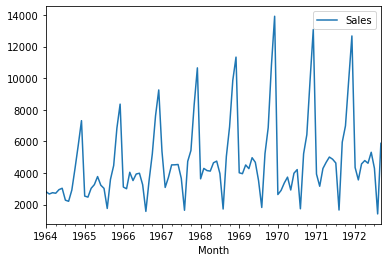

In [18]:
# seasonal data:
df.plot()

In [19]:
# perhaps during christmas, sales go up, 
# otherwise down

# adfuller test, p-value < 0.05

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
# similar to hypothesis test
# Ho(NULL) - data is not stationary
# H1(alt) - data is stationary

adfuller(df['Sales'])

(-1.833593056327623,
 0.363915771660245,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [22]:
def adfuller_test(sales):
    result = adfuller(sales)
    
    labels = ['ADF test statistics', 
              'p-value', 
              'Lags used', 
              'Number of observations used']
    
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
        
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis, reject null hypothesis & data is stationary')
    else:
        print('Weak edidence against null hypothesis, accept the null hypothesis & data is not stationary')

In [23]:
adfuller_test(df['Sales'])

ADF test statistics: -1.833593056327623
p-value: 0.363915771660245
Lags used: 11
Number of observations used: 93
Weak edidence against null hypothesis, accept the null hypothesis & data is not stationary


End goal: data must be stationary

In [24]:
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [25]:
# shift down
df['Sales'].shift(1)

Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [26]:
df['Sales first diff'] = df['Sales'] - df['Sales'].shift(1)

In [27]:
df.head()

,Sales,Sales first diff
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [28]:
# shift (12) because 1 year has 12 months
df['Seasonal first diff'] = df['Sales'] - df['Sales'].shift(12)

In [29]:
df.head()

,Sales,Sales first diff,Seasonal first diff
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [30]:
adfuller_test(df['Seasonal first diff'].dropna())

ADF test statistics: -7.626619157213164
p-value: 2.060579696813685e-11
Lags used: 0
Number of observations used: 92
Strong evidence against null hypothesis, reject null hypothesis & data is stationary


<AxesSubplot:xlabel='Month'>

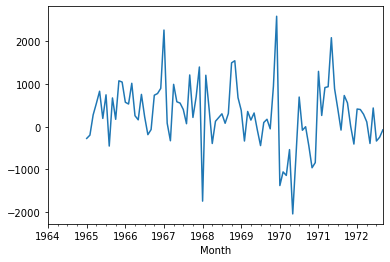

In [31]:
df['Seasonal first diff'].plot()

The plot above seems stationary as compared to the previous plot.

ARIMA:

- AR: auto regression, gives P
- I: integrity, gives d (differencing)
- MA: moving average, gives q (Auto correlation factor)

Hence, ARIMA gives (p,d,q)

PACF (Partial Auto Correlation Factor)

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [33]:
df.head(15)

,Sales,Sales first diff,Seasonal first diff
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [34]:
import matplotlib.pyplot as plt

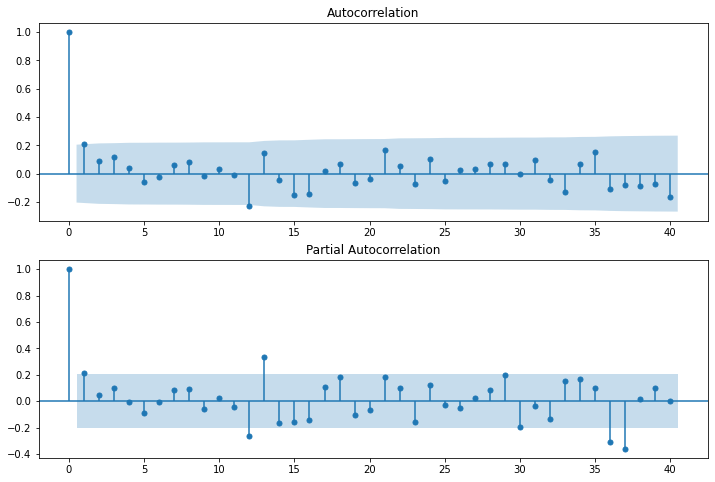

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal first diff'].iloc[13:],lags=40, ax = ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal first diff'].iloc[13:],lags=40, ax = ax2)



p, d, q

In [36]:
from statsmodels.tsa.arima_model import ARIMA

In [37]:
model = ARIMA(df['Sales'], order = (1,1,1))

/Users/puneetsran/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/puneetsran/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was pro

In [38]:
model = model.fit()

/Users/puneetsran/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Wed, 16 Jun 2021   AIC                           1910.251
Time:                        09:44:00   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7838     12.405      1.837      0.066      -1.530      47.098
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [40]:
df.shape

(105, 3)

In [41]:
# forecast
df['forecast'] = model.predict(start = 90, end=103, dynamic = True)

In [42]:
df.tail(20)

,Sales,Sales first diff,Seasonal first diff,forecast
Month,,,,
1971-02-01,3162.0,-772.0,263.0,NaN
1971-03-01,4286.0,1124.0,916.0,NaN
1971-04-01,4676.0,390.0,936.0,NaN
1971-05-01,5010.0,334.0,2083.0,NaN
1971-06-01,4874.0,-136.0,888.0,NaN
1971-07-01,4633.0,-241.0,416.0,473.056683
1971-08-01,1659.0,-2974.0,-79.0,218.357525
1971-09-01,5951.0,4292.0,730.0,107.730263
1971-10-01,6981.0,1030.0,557.0,59.679884


<AxesSubplot:xlabel='Month'>

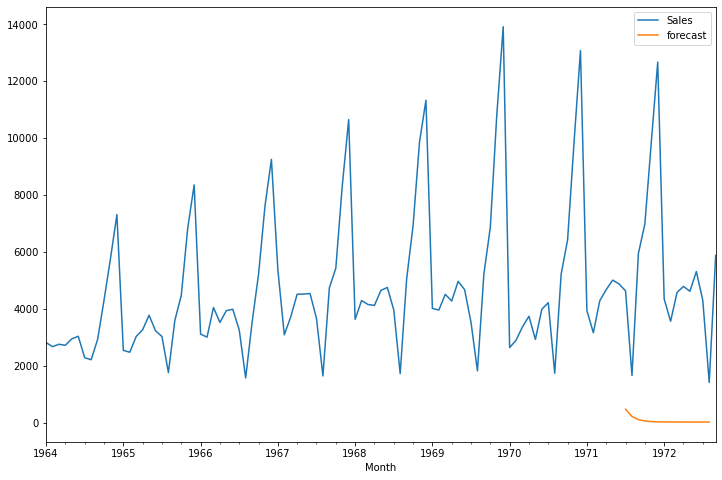

In [43]:
df[['Sales', 'forecast']].plot(figsize = (12,8))

For seasonal data, ARIMA did not do well as seen above.
- SARIMAX: seasonal arima

### SARIMAX model

In [44]:
import statsmodels.api as sm

In [45]:
# For seasonal_order pass p, d, q, shift_value (which is 12)
model = sm.tsa.statespace.SARIMAX(df['Sales'], 
                          order = (1,1,1), 
                          seasonal_order=(1, 1, 1, 12))

/Users/puneetsran/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/puneetsran/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [46]:
results = model.fit()

In [47]:
df['forecast_SARIMAX'] = results.predict(start = 90, end = 103, dynamic = True)

In [48]:
df.tail(20)

,Sales,Sales first diff,Seasonal first diff,forecast,forecast_SARIMAX
Month,,,,,
1971-02-01,3162.0,-772.0,263.0,NaN,NaN
1971-03-01,4286.0,1124.0,916.0,NaN,NaN
1971-04-01,4676.0,390.0,936.0,NaN,NaN
1971-05-01,5010.0,334.0,2083.0,NaN,NaN
1971-06-01,4874.0,-136.0,888.0,NaN,NaN
1971-07-01,4633.0,-241.0,416.0,473.056683,4437.325806
1971-08-01,1659.0,-2974.0,-79.0,218.357525,2050.747963
1971-09-01,5951.0,4292.0,730.0,107.730263,5493.376884
1971-10-01,6981.0,1030.0,557.0,59.679884,6752.038618


<AxesSubplot:xlabel='Month'>

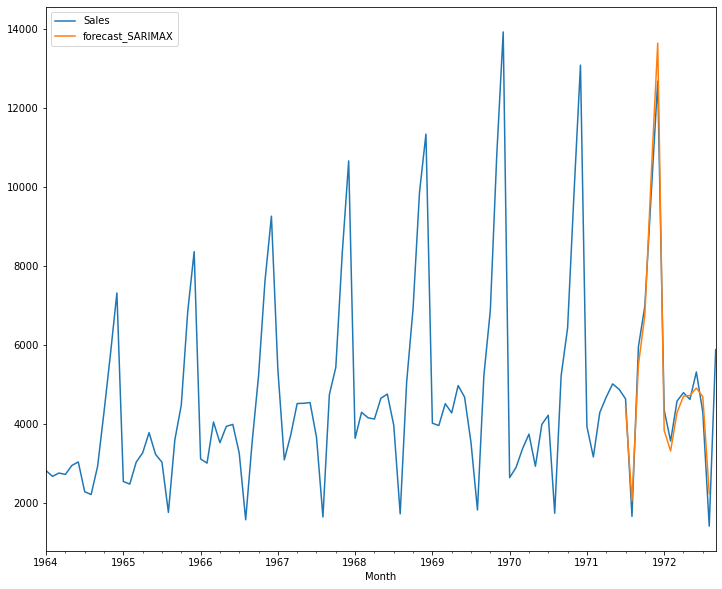

In [49]:
# view plot
df[['Sales', 'forecast_SARIMAX']].plot(figsize=(12,10))

SARIMAX performed much better when compared to ARIMA

### dateoffset

In [50]:
from pandas.tseries.offsets import DateOffset

# add, for 24 months

In [51]:
df.index[-1]

Timestamp('1972-09-01 00:00:00')

In [52]:
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(0,24)]

In [53]:
future_dates[1:]

[Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [54]:
future_dataset = pd.DataFrame(index =future_dates[1:], columns =df.columns)

In [55]:
future_dataset.tail()

,Sales,Sales first diff,Seasonal first diff,forecast,forecast_SARIMAX
1974-04-01,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN


In [56]:
future_df = pd.concat([df, future_dataset])

In [57]:
future_df.shape

(128, 5)

In [58]:
future_df['forecast_SARIMAX_2'] = results.predict(start = 104, end = 124, dynamic = True)

<AxesSubplot:>

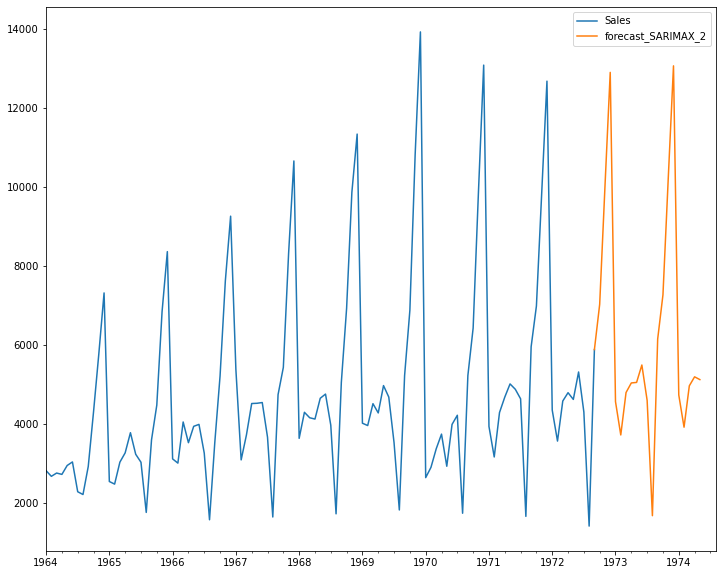

In [59]:
future_df[['Sales', 'forecast_SARIMAX_2']].plot(figsize=(12,10))

The forecast is very much in agreement with the existing trend.